In [1]:
from util import CreditRiskConformalPredictor

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib.colors import LinearSegmentedColormap

train = pd.read_csv('data1/train_process.csv',encoding = 'gbk')
test = pd.read_csv('data1/test_process.csv',encoding = 'gbk')
cal = pd.read_csv('data1/val_process.csv',encoding = 'gbk')

train = train.drop(columns = ["Unnamed: 0"]).fillna(0)
test = test.drop(columns = ["Unnamed: 0"]).fillna(0)
cal = cal.drop(columns = ["Unnamed: 0"]).fillna(0)

# 特征选择
selected_columns = ['x268','x269','x154','x155','x270','x4','x138','x303','x264','x309','x145','x160','x310',
 'x62','x328','x21','x147','x258','x6','x265','x19','x236','x186','x149','x170','x3','x314','x331','x267']
X, Y = train[selected_columns].values,  train["Y"].values
X_cal, y_cal = cal[selected_columns].values, cal["Y"].values
X_test, y_test = test[selected_columns].values, test["Y"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_cal = scaler.fit_transform(X_cal)
X_test = scaler.fit_transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=42)

map_values = {"AAA":0,"AA":1,"A":2}
class_names = {0:"AAA",1:"AA",2:"A"}
vectorized_map = np.vectorize(lambda x: map_values[x])
y_cal = vectorized_map(y_cal)
y_test = vectorized_map(y_test)
y_train = vectorized_map(y_train)

n_estimators=100
max_features="sqrt"
random_state = 42
model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        # max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1
    )
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:

def compute_adaptive_scores(probs: np.ndarray, labels: np.ndarray) -> np.ndarray:
    n, K = probs.shape
    scores = np.zeros(n)
    for i in range(n):
        pi = np.argsort(probs[i])[::-1]
        srt = np.cumsum(probs[i, pi])
        k = np.where(pi == labels[i])[0][0]
        scores[i] = srt[k]
    return scores

X_prob = model.predict_proba(X_cal)
y_labels = model.predict(X_cal)
true_indice = y_labels == y_cal
false_indice = y_labels != y_cal
Xmax = X_prob.max(axis = 1)
plt.hist(Xmax[true_indice], label = "True",density = False, bins = 8)
plt.hist(Xmax[false_indice], label = "False", density = False, bins = 8)
plt.legend()
X_prob[true_indice].max(axis = 1).mean(), X_prob[false_indice].max(axis = 1).mean()


true_scores = compute_adaptive_scores(X_prob[true_indice],y_cal[true_indice])
false_scores = compute_adaptive_scores(X_prob[false_indice],y_cal[false_indice])
plt.figure(figsize = (8,6), dpi = 300)
plt.hist(false_scores, label = "False",density = True, bins = 20)
plt.hist(true_scores, label = "true",density = True, bins = 8)
plt.legend()
plt.title("true/false prediction scores distribution")


In [ ]:
conformal_predictor = CreditRiskConformalPredictor(alpha = 0.1, method = "standard", 
                                                   class_conditional = False, model = model)
conformal_predictor.calibrate(X_cal, y_cal)
print("qhat值为：", conformal_predictor.qhat)
results = conformal_predictor.evaluate_coverage(X_test, y_test)
print(results)
conformal_predictor.visualize_results(X_test, y_test, class_names)
conformal_predictor.analyze_prediction_sets(X_test, y_test, class_names = class_names)

{'coverage': 0.9090909090909091, 'average_set_size': 1.4318181818181819, 'class_coverage': {np.int64(0): np.float64(0.96), np.int64(1): np.float64(0.9545454545454546), np.int64(2): np.float64(0.7368421052631579)}, 'class_average_set_size': {np.int64(0): np.float64(1.56), np.int64(1): np.float64(1.2954545454545454), np.int64(2): np.float64(1.5789473684210527)}, 'avg_FSC': np.float64(0.7132183908045979), 'min_FSC': np.float64(0.5), 'SSC': [np.float64(0.84), np.float64(1.0)]}


/root/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [ ]:
def _1compare_multiple_vs_single_true(X, prediction_sets) -> None:
    maps = {"[False False  True]":"{A}",'[False  True  True]':"{A,AA}",'[False  True False]':"{AA}"}
    target_sets = [
        np.array([False, False, True]),
        np.array([False, True, True]),
        np.array([False, True, False])]
    n_features = X.shape[1]
    features_per_plot = 6 
    n_plots = (n_features + features_per_plot - 1) // features_per_plot
    for plot_idx in range(n_plots):
        start_feature = plot_idx * features_per_plot
        end_feature = min((plot_idx + 1) * features_per_plot, n_features)
        plt.figure(figsize=(5 * (end_feature - start_feature), 6), dpi=300)
        
        for i, feature_idx in enumerate(range(start_feature, end_feature)):
            plt.subplot(1, end_feature - start_feature, i + 1)
            
            data = []
            labels = []
            
            for target_set in target_sets:
                mask = np.all(prediction_sets == target_set, axis=1)
                group_idx = np.where(mask)[0]
                
                if len(group_idx) > 0:
                    data.append(X[group_idx, feature_idx])
                    labels.append(maps[str(target_set)])
            
            if data:
                sns.boxplot(data=data)
                plt.xticks(range(len(labels)), labels, rotation=10)
                name = selected_columns[feature_idx]
                plt.title(f'{name}')
        
        plt.tight_layout()
        plt.savefig("4.jpg")


prediction_sets = conformal_predictor.predict(X_test)
_1compare_multiple_vs_single_true(X_test, prediction_sets)

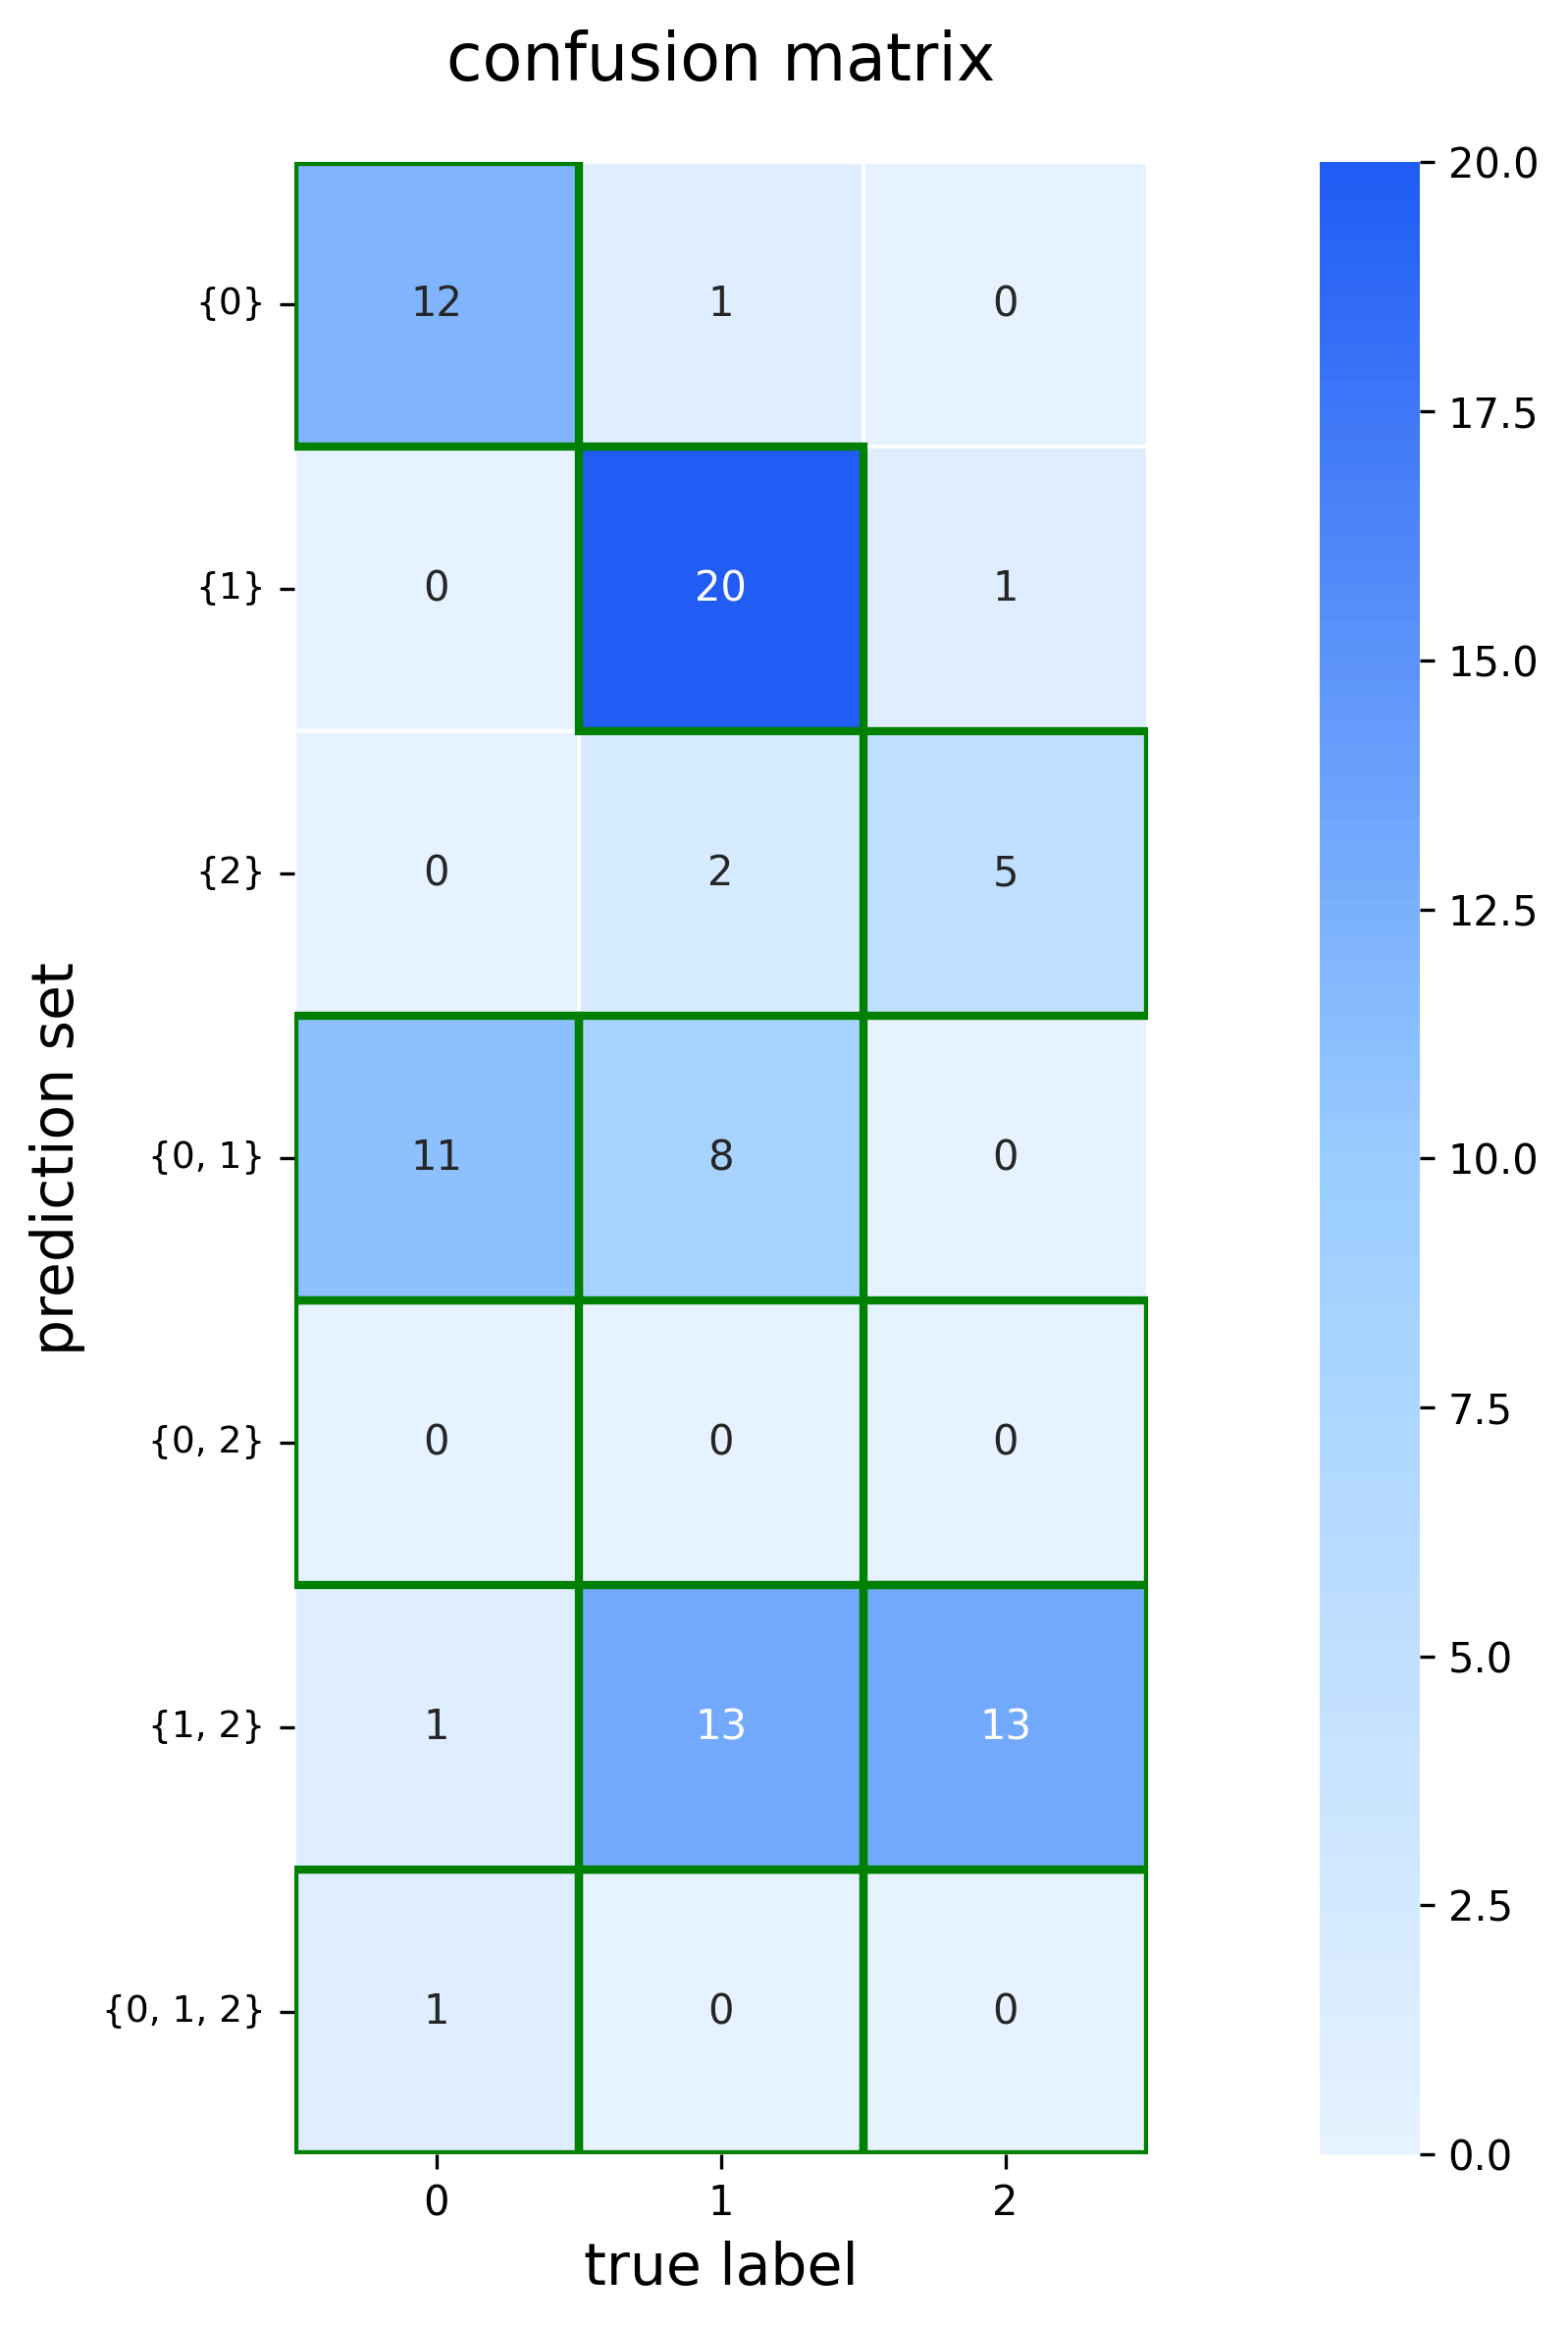

In [ ]:
def prediction_set_to_classes(pred_set):
    """将布尔型预测集转换为类别索引列表"""
    return np.where(pred_set)[0].tolist()

def generate_prediction_set_confusion_matrix(true_labels, prediction_sets, class_names=None):
    n_classes = prediction_sets.shape[1]
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]
    all_possible_sets = []
    for r in range(1, n_classes + 1):
        for subset in itertools.combinations(range(n_classes), r):
            all_possible_sets.append(subset)
    
    matrix = np.zeros((len(all_possible_sets), n_classes), dtype=int)
    
    for true_label, pred_set in zip(true_labels, prediction_sets):
        pred_classes = prediction_set_to_classes(pred_set)
        pred_set_tuple = tuple(sorted(pred_classes))
        set_index = all_possible_sets.index(pred_set_tuple)
        matrix[set_index, true_label] += 1
    
    colors = [(0.9, 0.95, 1.0), (0.6, 0.8, 1.0), (0.13, 0.36, 0.96)]
    cmap = LinearSegmentedColormap.from_list('BlueCustom', colors, N=100)
    
    plt.figure(figsize=(12, 8),dpi = 300)
    ax = sns.heatmap(matrix, annot=True, fmt='d', cmap=cmap, 
                     xticklabels=class_names, cbar=True, square=True,
                     linewidths=0.5, annot_kws={"size": 10})
    
    plt.xlabel('true label', fontsize=14)
    plt.ylabel('prediction set', fontsize=14)
    plt.title('confusion matrix', fontsize=16, pad=20)
    
    set_labels = []
    for s in all_possible_sets:
        label = '{' + ', '.join([class_names[i] for i in s]) + '}'
        set_labels.append(label)
    
    plt.yticks(rotation=0)
    ax.set_yticklabels(set_labels, fontsize=9)
    
    for i, s in enumerate(all_possible_sets):
        for j in range(n_classes):
            if j in s:
                rect = plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='green', linewidth=2)
                ax.add_patch(rect)
    plt.tight_layout()
    plt.savefig("2.jpg")
    return matrix, all_possible_sets

prediction_sets = conformal_predictor.predict(X_test)
matrix, sets = generate_prediction_set_confusion_matrix(y_test, prediction_sets)